# **文章カテゴリ分類問題における再帰型ニューラルネットワーク(RNN)の有効性の検証(先取りPython第15回)**
* 全結合NNとRNNで文章カテゴリ分類問題を解き、精度の比較を行う
* 使用するデータセット：livedoorニュースコーパス

## **流れ**
* テキスト前処理
  * ファイルからテキストの読み込み
  * 読み込んだテキストを形態素解析
  * 訓練データ(形態素)から辞書を作成
  * 辞書を基にテキストをIDに読み替える
  * テキスト(ID)の長さを統一させるパディングを行う…(*1)
* 全結合NN
  * (*1)をBag of Wordsの形式に変換したものを入力ベクトルとする
  * 学習
* RNN
  * (*2)を入力ベクトルとする(Embedding層で単語分散表現に変換)
  * 学習

In [ ]:
# MeCabのインストール
!apt install aptitude swig
!aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y
!pip install mecab-python3

!git clone --depth 1 https://github.com/neologd/mecab-ipadic-neologd.git
!echo yes | mecab-ipadic-neologd/bin/install-mecab-ipadic-neologd -n -a

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  aptitude-common libcgi-fast-perl libcgi-pm-perl libclass-accessor-perl
  libcwidget3v5 libencode-locale-perl libfcgi-perl libhtml-parser-perl
  libhtml-tagset-perl libhttp-date-perl libhttp-message-perl libio-html-perl
  libio-string-perl liblwp-mediatypes-perl libparse-debianchangelog-perl
  libsigc++-2.0-0v5 libsub-name-perl libtimedate-perl liburi-perl libxapian30
  swig3.0
Suggested packages:
  aptitude-doc-en | aptitude-doc apt-xapian-index debtags tasksel
  libcwidget-dev libdata-dump-perl libhtml-template-perl libxml-simple-perl
  libwww-perl xapian-tools swig-doc swig-examples swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  aptitude aptitude-common libcgi-fast-perl lib

In [ ]:
cp -r /usr/lib/x86_64-linux-gnu/mecab/dic/mecab-ipadic-neologd /usr/local/etc/mecabrc

In [ ]:
# 単語分散表現の学習済みモデル
# !wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ja.300.vec.gz -P data/

# 使用するデータのダウンロード
!wget https://www.rondhuit.com/download/ldcc-20140209.tar.gz
!tar -zxvf ldcc-20140209.tar.gz

ストリーミング出力は最後の 5000 行に切り捨てられました。
text/smax/smax-6833494.txt
text/smax/smax-6833579.txt
text/smax/smax-6834422.txt
text/smax/smax-6834562.txt
text/smax/smax-6834765.txt
text/smax/smax-6834990.txt
text/smax/smax-6835318.txt
text/smax/smax-6838218.txt
text/smax/smax-6838260.txt
text/smax/smax-6838332.txt
text/smax/smax-6838453.txt
text/smax/smax-6838514.txt
text/smax/smax-6838627.txt
text/smax/smax-6838702.txt
text/smax/smax-6842164.txt
text/smax/smax-6842219.txt
text/smax/smax-6842269.txt
text/smax/smax-6842402.txt
text/smax/smax-6842629.txt
text/smax/smax-6842882.txt
text/smax/smax-6843206.txt
text/smax/smax-6845003.txt
text/smax/smax-6847081.txt
text/smax/smax-6849018.txt
text/smax/smax-6850114.txt
text/smax/smax-6850391.txt
text/smax/smax-6850789.txt
text/smax/smax-6851590.txt
text/smax/smax-6851919.txt
text/smax/smax-6853063.txt
text/smax/smax-6853346.txt
text/smax/smax-6853751.txt
text/smax/smax-6854198.txt
text/smax/smax-6855347.txt
text/smax/smax-6855946.txt
text/smax/smax-6856195.

## **MeCabの設定とテキストの抽出・配列化**

In [ ]:
import MeCab
import subprocess
import os
import numpy as np

# 形態素解析をして、名詞だけ取り出す
def tokenize(text):
    node = mecab.parseToNode(text)
    while node:
        # if node.feature.split(',')[0] == '名詞':
        yield node.surface.lower()
        node = node.next

# 記事群のdictについて、形態素解析をしてリストに返す
def get_words(contents):
    ret = []
    for  content in contents:
        ret.append(" ".join(get_words_main(content)))
    return ret

# 一つの記事を形態素解析して返す
def get_words_main(content):
    return [token for token in tokenize(content)]


cmd='echo `mecab-config --dicdir`"/mecab-ipadic-neologd"'
path = (subprocess.Popen(cmd, stdout=subprocess.PIPE,
                           shell=True).communicate()[0]).decode('utf-8')
path = "-d {0}".format(path)

mecab = MeCab.Tagger(path)


#ファイルの読み込み、及びタイトル・本文データの取得
path_list = ["dokujo-tsushin", "it-life-hack", "kaden-channel", "livedoor-homme", "movie-enter", "peachy", "smax", "sports-watch", "topic-news"]
# path_list = ["dokujo-tsushin", "it-life-hack", "kaden-channel"]

w_list = []
labels = []

for p_list in path_list:
    path = "./text/"+p_list
    #ディレクトリ内の全ファイル名を取得
    f_list = os.listdir(path)

    for lists in f_list:
        with open("./text/"+ p_list+ "/"+lists, encoding="utf-8_sig") as f:
            next(f)
            next(f)
            #全角スペースや改行の削除
            w = f.read().replace('\u3000','').replace('\n','')

            w_list.append(w)
            labels.append(path_list.index(p_list))

In [ ]:
import pandas as pd
df = pd.DataFrame(w_list, columns=["sentence"])
df["label"] = labels
df

,sentence,label
0,くさったよめがあらわれた！vol.03「いつも私と同じことばかり考えてる君が好き！」 pre...,0
1,つける？ つけない？ 独女の家計簿実在した武士の家計簿を元に制作された映画「武士の家計簿」。...,0
2,電車の中で携帯カチカチ……皆、何みているの？「ここ数年、何か本を読んだかな？って考えたんだけ...,0
3,結婚式はオンナの自意識披露パーティー？さあ、今年もそろそろジューンブライドの季節が到来です。...,0
4,“大きいほう”のお悩みは「こくみん腸査」でスッキリ！あなたには何でも相談できる友人はいるだろ...,0
...,...,...
7371,「タニタ調子こいてる」「刑務所メシより酷い」ヘルシー弁当の内容に物議5日、家庭用・業務用の計...,8
7372,レナウンが唖然とした「残酷」な中国市場23日夜に放送されたNHKスペシャル「“中国人ボスがや...,8
7373,ラッパーのZeebraが″中二病″の生み親・伊集院光に突撃「クソみてえな文化を助長するだけ」...,8
7374,池袋のクラブハウスに警察が大規模なガサ入れ、参加者たち怒り露わ11日、池袋のクラブへ警察によ...,8


## **テキストの形態素解析と訓練・検証データ分割**

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
import gensim

def build_vocabulary(texts, num_words=None):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=num_words, oov_token='<UNK>'
    )
    tokenizer.fit_on_texts(texts)
    return tokenizer

def filter_embeddings(embeddings, vocab, num_words, dim=300):
    """Filter word vectors.
    Args:
        embeddings: a dictionary like object.
        vocab: word-index lookup table.
        num_words: the number of words.
        dim: dimension.

    Returns:
        numpy array: an array of word embeddings.
    """
    _embeddings = np.zeros((num_words, dim))
    for word in vocab:
        if word in embeddings:
            word_id = vocab[word]
            if word_id >= num_words:
                continue
            _embeddings[word_id] = embeddings[word]

    return _embeddings

def load_fasttext(filepath, binary=False):
    """Loads fastText vectors.
    Args:
        filepath (str): a path to a fastText file.

    Return:
        model: KeyedVectors
    """
    model = gensim.models.KeyedVectors.load_word2vec_format(filepath, binary=binary)
    return model

# Set hyper-parameters.
batch_size = 128
epochs = 24
maxlen = 1000
model_path = 'models/rnn_model.h5'
num_words = 40000
num_label = 9

# 全てのテキストを形態素解析した結果を返す
x = get_words(df["sentence"])
x_train, x_test, y_train, y_test = train_test_split(x, df["label"],
                                                    test_size=0.2,
                                                    random_state=42)

In [ ]:
x[0]

' くさっ た よ め が あらわれ た ！ vol . 03 「 いつも 私 と 同じ こと ばかり 考え てる 君 が 好き ！ 」 present ed by ゆるっ と cafe 独女 の 皆さん こんにちは ！ 毎度 おなじみ （ ？ ） 「 くさっ た よ め が あらわれ た 」 の 漫画家 ・ うえやま洋介犬 の くさっ た よ め で ござい ます ！ 季節 的 に も いい 感じ に 腐っ た 妄想 に 優しい 季節 に なり まし た ね ！ 寒い から くっつい ちゃ えよ ！ 寄り添えよ ！ ただし … … ！ 男 同士 で ！ コタツ の 中 に 突っ込ん だ 足 が ぶつかっ て 蹴り 合っ たり 、 絡め たり し て 愛 を 深め たり … … 寒い 外 で 寄り添っ て 歩い て 肩 を 抱い たり 、 巻い て い た マフラー を 相手 に 巻い て あげ たり 、 温め あっ たり とか … … お ステキ な 限り です 。 白い 息 を 吐き ながら 窓辺 で 雪が降る 空 を 眺め てる 男 を 、 後ろ から 男 が 抱き締め たり すれ ば いい よ ！ とか 連 連 と 妄想 垂れ流 し て み まし た こんな 私 です が 、 今回 も 宜しく お願い し ます 。 「 類は友を呼ぶ 」 と は 本当に よく 言っ た もの です 。 私 と 旦那 の 友達 で 、 漫画家 の うさみ☆ さん という 方 が いらっしゃい まし て 、 旦那 が 今回 の 漫画 を 描く にあたって その 方 に も 話 を 聞い て 、 彼女 と 私 の 妄想 と 比較 しよ う と し た 模様 。 うさみ☆ さん に 話 を 聞い て 帰っ て 来 た 旦那 は 云い まし た 。 「 何で キミ たち 、 振っ た 話題 に対して 、 妄想 と 意見 が そんなに 数 分 違わ ず 一緒 な の ？ 」 そんなに 同じ だっ た の か … … と 、 ちょっと 吃驚 は し まし た が 、 同じ 腐女子 で 似 た 思考 を 持っ てる から こそ の 「 友達 」 なのだ から おかしく は 無い よう な 気 は し ます 。 うさみ☆ さん も とても キリッ ！ と し た 表情 で 、 「 腐女子 とし

## **訓練データ(形態素)から辞書を作成・辞書を基にテキストをIDに読み替える…(*1)**

In [ ]:
# 訓練データから単語辞書(或いはベクトル)を作成
vocab = build_vocabulary(x_train, num_words)
# 辞書を用いて、テキスト(形態素解析済み)をIDに置き換える
x_train_seq = vocab.texts_to_sequences(x_train)
x_test_seq = vocab.texts_to_sequences(x_test)

## **テキスト(ID)の長さを統一させるパディングを行う…(*2)**

In [ ]:
from gensim.models.word2vec import Word2Vec, Text8Corpus

# 最大長をmaxlenの長さにする
x_train_pad = pad_sequences(x_train_seq, maxlen=maxlen, truncating='post')
x_test_pad = pad_sequences(x_test_seq, maxlen=maxlen, truncating='post')

# 学習済みの単語分散表現を読み込む
# wv = load_fasttext('data/cc.ja.300.vec.gz')
# wv.save("models/model_word2vec.bin")
wv_pre = open('./drive/My Drive/bda-data/model_word2vec.bin', 'rb')
# wv = Word2Vec.load('./drive/My Drive/bda-data/model_word2vec.bin')
wv = filter_embeddings(wv_pre, vocab.word_index, num_words)

# print(np.array(x_train).shape)
# print(np.array(x_test).shape)
pd.DataFrame(x_train_pad)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,196,20,86,135,19,426,299,191,17,12017,469,1114,1189,394,592,3,487,5458,6,291,131,15,11,14,7926,982,119,13,6,957,136,17,7926,23990,706,1241,326,251,7926,546
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2,13770,1893,2,7928,2,1,366,685,35,26697,1,13111,1,20,13771,35,6899,30268,17,18580,17,18581,20038,2,6899,18581,17,35174,1,2,1,35175,19,50,122,321,147,211,747
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,5715,12,8,41,42,11517,5799,23,2380,43,17,473,215,209,41,269,780,3,686,2863,217,8,35177,42,91,43,17,2909,5,5215,55,81,534,31,693,3,1434,630,23995,3627
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,34,5135,3,13772,27,3,17323,40,2,364,16,7,1796,2428,11,6016,3,49,1,48,6,2020,3,171,2126,10,4979,5,600,184,12,45,9,22,4,17,4009,3425,1,496
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,916,15,11,12509,7,10659,10,3582,21,59,2,1549,18,169,8,21,112,2,1,2,9354,531,4203,2,1085,7,1420,18,155,16,1659,13,12,743,6,2280,3,88,11,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5895,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,19,2,20651,95,20960,421,35,4664,12302,35504,11362,70,324,35,5069,4997,50,252,17,196,20,86,135,19,17,196,20,86,135,19,426,299,191,17,18286,1038,17,4968,17,10060
5896,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,86,135,19,426,299,191,17,4415,347,454,8354,237,2,39,454,8354,2006,38,12,39,454,8354,1851,38,6,129,146,422,667,5,5594,5,1284,248,335,206,25897,345,132,4415
5897,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,31,119,104,150,34,2175,529,6,131,15,11,266,266,445,12,268,62,445,190,929,27,807,94,50,252,17,196,20,86,135,19,17,196,20,86,135,19,426,299,191
5898,3143,2911,281,5,1161,4,14,9986,6224,5,21285,33,31,13,6224,5,1039,5,4527,14,100,2516,13,12,752,55,8,139,79,46,4,230,2,3759,115,7,71,3,892,3796,...,112,2,1317,8,140,16,27189,117,133,49,608,1822,9,114,2992,48,12,282,9,205,54,11,4,9835,143,2706,7,4125,9,224,11,309,2,128,5,527,8,3243,9,166


## **全結合NN**
* (*1)をBag of Wordsの形式に変換したものを入力ベクトルとする
* 学習

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from keras.layers import Input, Dense
from keras.models import Model

class DNNModel:

    def __init__(self, input_dim, output_dim):
      self.input = Input(shape=(input_dim,))
      self.dense_input = Dense(512, activation='relu')
      self.dense = Dense(512, activation='relu')
      self.y = Dense(output_dim, activation='softmax')

    def build(self):
      inputs = self.input
      x = self.dense_input(inputs)
      x = self.dense(x)
      y = self.y(x)
      return Model(inputs=inputs, outputs=y)

# ワンホットエンコードを行って特徴量ベクトルに変換
tokenizer = Tokenizer(num_words=maxlen)
x_train_dnn = tokenizer.sequences_to_matrix(x_train_seq, mode="binary")
x_test_dnn = tokenizer.sequences_to_matrix(x_test_seq, mode="binary")

# Build models.
model = DNNModel(maxlen, num_label).build()

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Preparing callbacks.
callbacks = [
    EarlyStopping(patience=3),
    # ModelCheckpoint(model_path, save_best_only=True)
]

hist = model.fit(x=x_train_dnn,
          y=y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2,
          callbacks=callbacks)  # starts training

Train on 4720 samples, validate on 1180 samples
Epoch 1/24
4720/4720 [==============================] - 0s 50us/step - loss: 0.7033 - accuracy: 0.7881 - val_loss: 0.2798 - val_accuracy: 0.9110
Epoch 2/24
4720/4720 [==============================] - 0s 29us/step - loss: 0.1234 - accuracy: 0.9655 - val_loss: 0.1955 - val_accuracy: 0.9339
Epoch 3/24
4720/4720 [==============================] - 0s 31us/step - loss: 0.0442 - accuracy: 0.9886 - val_loss: 0.1979 - val_accuracy: 0.9347
Epoch 4/24
4720/4720 [==============================] - 0s 30us/step - loss: 0.0176 - accuracy: 0.9979 - val_loss: 0.2003 - val_accuracy: 0.9424
Epoch 5/24
4720/4720 [==============================] - 0s 29us/step - loss: 0.0089 - accuracy: 0.9994 - val_loss: 0.1961 - val_accuracy: 0.9449


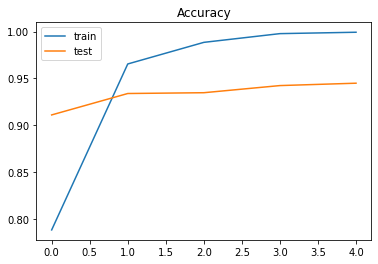

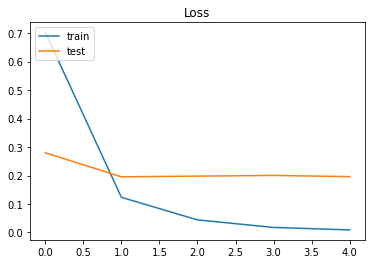

In [ ]:
import matplotlib.pyplot as plt

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## **RNN**
* (*2)を入力ベクトルとする
* 学習

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Embedding, SimpleRNN

class RNNModel:

    def __init__(self, input_dim, output_dim,
                 emb_dim=300, hid_dim=100,
                 embeddings=None, trainable=True):
        self.input = Input(shape=(None,), name='input')
        if embeddings is None:
            self.embedding = Embedding(input_dim=input_dim,
                                       output_dim=emb_dim,
                                       mask_zero=True,
                                       trainable=trainable,
                                       name='embedding')
        else:
            self.embedding = Embedding(input_dim=embeddings.shape[0],
                                       output_dim=embeddings.shape[1],
                                       mask_zero=True,
                                       trainable=trainable,
                                       weights=[embeddings],
                                       name='embedding')
        self.rnn = SimpleRNN(hid_dim, name='rnn')
        self.fc = Dense(output_dim, activation='softmax')

    def build(self):
        x = self.input
        embedding = self.embedding(x)
        output = self.rnn(embedding)
        y = self.fc(output)
        return Model(inputs=x, outputs=y)

# Build models.
# models = RNNModel(num_words, num_label, embeddings=None).build()
models = RNNModel(num_words, num_label, embeddings=wv).build()

models.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Preparing callbacks.
callbacks = [
    EarlyStopping(patience=3),
    # ModelCheckpoint(model_path, save_best_only=True)
]

# Train the model.
hist = models.fit(x=x_train_pad,
          y=y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2,
          callbacks=callbacks)

Epoch 1/24
37/37 [==============================] - 48s 1s/step - loss: 1.8742 - accuracy: 0.4076 - val_loss: 1.5664 - val_accuracy: 0.5441
Epoch 2/24
37/37 [==============================] - 48s 1s/step - loss: 0.7316 - accuracy: 0.9453 - val_loss: 1.3443 - val_accuracy: 0.5653
Epoch 3/24
37/37 [==============================] - 47s 1s/step - loss: 0.1268 - accuracy: 0.9972 - val_loss: 1.3294 - val_accuracy: 0.5525
Epoch 4/24
37/37 [==============================] - 47s 1s/step - loss: 0.0322 - accuracy: 0.9992 - val_loss: 1.3162 - val_accuracy: 0.5576
Epoch 5/24
37/37 [==============================] - 47s 1s/step - loss: 0.0164 - accuracy: 0.9992 - val_loss: 1.3323 - val_accuracy: 0.5559
Epoch 6/24
37/37 [==============================] - 46s 1s/step - loss: 0.0108 - accuracy: 0.9994 - val_loss: 1.3417 - val_accuracy: 0.5508
Epoch 7/24
37/37 [==============================] - 46s 1s/step - loss: 0.0079 - accuracy: 0.9996 - val_loss: 1.3543 - val_accuracy: 0.5525


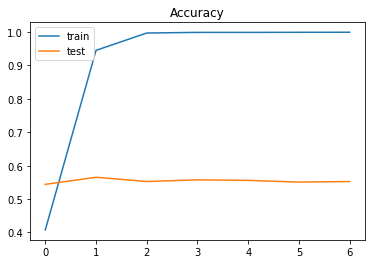

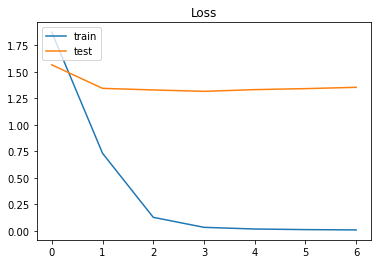

In [ ]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# LSTM版

In [ ]:
# ライブラリをロード
import numpy as np
from keras.preprocessing import sequence
from keras import models
from keras import layers

# 利用したい特徴量の数を指定
number_of_features = 1000

# Use padding or truncation to make each observation have 400 features
features_train = sequence.pad_sequences(x_train_seq, maxlen=1000)
features_test = sequence.pad_sequences(x_test_seq, maxlen=1000)

# ニューラルネットワークの作成を開始
network = models.Sequential()

embeddings=wv
# 埋め込み層を追加
# network.add(layers.Embedding(input_dim=number_of_features, output_dim=128,))
network.add(layers.Embedding(input_dim=embeddings.shape[0], output_dim=embeddings.shape[1], weights=[embeddings]))


# 128ユニットのLSTM層を追加
network.add(layers.LSTM(units=128))

# 活性化関数としてシグモイド関数を用いる全結合層を追加
network.add(layers.Dense(units=9, activation="softmax"))

# ニューラルネットワークをコンパイル
network.compile(loss="sparse_categorical_crossentropy", # クロスエントロピ
                optimizer="Adam", # Adam optimization
                metrics=["accuracy"]) # 性能指標は精度

# ニューラルネットワークを訓練
history = network.fit(features_train, # 特徴量
                      y_train, # ターゲット
                      epochs=40, # エポック数
                      verbose=1, # エポック毎の出力を抑制
                      batch_size=100, # 1バッチあたりの観測値数
                      callbacks=callbacks,
                      validation_data=(features_test, y_test)) # テストデータ

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 5900 samples, validate on 1476 samples
Epoch 1/40
5900/5900 [==============================] - 95s 16ms/step - loss: 1.5054 - accuracy: 0.5466 - val_loss: 0.8965 - val_accuracy: 0.6999
Epoch 2/40
5900/5900 [==============================] - 94s 16ms/step - loss: 0.6103 - accuracy: 0.8300 - val_loss: 0.4116 - val_accuracy: 0.8665
Epoch 3/40
5900/5900 [==============================] - 93s 16ms/step - loss: 0.1843 - accuracy: 0.9556 - val_loss: 0.4124 - val_accuracy: 0.8740
Epoch 4/40
5900/5900 [==============================] - 93s 16ms/step - loss: 0.0658 - accuracy: 0.9846 - val_loss: 0.3774 - val_accuracy: 0.8923
Epoch 5/40
5900/5900 [==============================] - 92s 16ms/step - loss: 0.0267 - accuracy: 0.9951 - val_loss: 0.3732 - val_accuracy: 0.8909
Epoch 6/40
5900/5900 [==============================] - 92s 16ms/step - loss: 0.0120 - accuracy: 0.9983 - val_loss: 0.3705 - val_accuracy: 0.8984
Epoch 7/40
5900/5900 [==============================] - 93s 16ms/step - loss

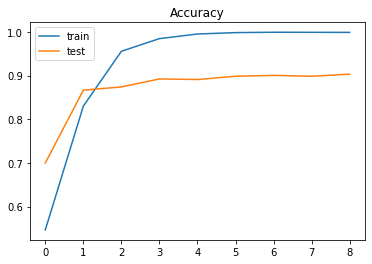

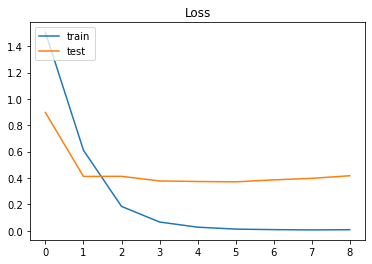

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
features_train = tokenizer.sequences_to_matrix(x_train_seq, mode="binary")
features_train

array([[0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.]])

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Embedding, SimpleRNN, LSTM

class LSTMModel:

    def __init__(self, input_dim, output_dim,
                 emb_dim=300, hid_dim=100,
                 embeddings=None, trainable=True):
        self.input = Input(shape=(None,), name='input')
        if embeddings is None:
            self.embedding = Embedding(input_dim=input_dim,
                                       output_dim=emb_dim,
                                       mask_zero=True,
                                       trainable=trainable,
                                       name='embedding')
        else:
            self.embedding = Embedding(input_dim=embeddings.shape[0],
                                       output_dim=embeddings.shape[1],
                                       mask_zero=True,
                                       trainable=trainable,
                                       weights=[embeddings],
                                       name='embedding')
        self.lstm = LSTM(hid_dim, name='lstm')
        self.fc = Dense(output_dim, activation='softmax')

    def build(self):
        x = self.input
        embedding = self.embedding(x)
        output = self.lstm(embedding)
        y = self.fc(output)
        return Model(inputs=x, outputs=y)

# model = LSTMModel(num_words, num_label, embeddings=None).build()
model = LSTMModel(num_words, num_label, embeddings=wv).build()

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Preparing callbacks.
callbacks = [
    EarlyStopping(patience=3),
    # ModelCheckpoint(model_path, save_best_only=True)
]

# Train the model.
hist = model.fit(x=x_train_pad,
          y=y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2,
          callbacks=callbacks)

Epoch 1/24
37/37 [==============================] - 84s 2s/step - loss: 1.8221 - accuracy: 0.4566 - val_loss: 1.3243 - val_accuracy: 0.6042
Epoch 2/24
37/37 [==============================] - 80s 2s/step - loss: 0.8413 - accuracy: 0.7790 - val_loss: 0.7167 - val_accuracy: 0.7924
Epoch 3/24
37/37 [==============================] - 78s 2s/step - loss: 0.3667 - accuracy: 0.8987 - val_loss: 0.5877 - val_accuracy: 0.8059
Epoch 4/24
37/37 [==============================] - 77s 2s/step - loss: 0.1552 - accuracy: 0.9678 - val_loss: 0.4748 - val_accuracy: 0.8492
Epoch 5/24
37/37 [==============================] - 76s 2s/step - loss: 0.0754 - accuracy: 0.9869 - val_loss: 0.5068 - val_accuracy: 0.8466
Epoch 6/24
37/37 [==============================] - 75s 2s/step - loss: 0.0398 - accuracy: 0.9941 - val_loss: 0.5282 - val_accuracy: 0.8432
Epoch 7/24
37/37 [==============================] - 75s 2s/step - loss: 0.0211 - accuracy: 0.9970 - val_loss: 0.5288 - val_accuracy: 0.8432


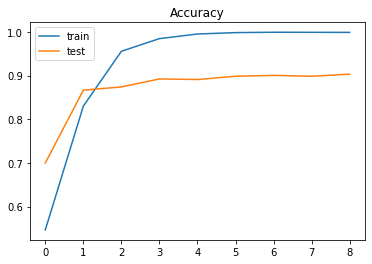

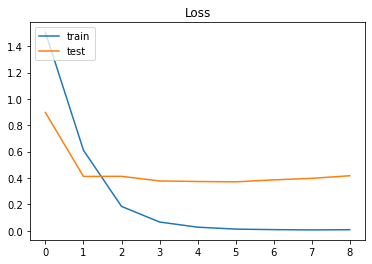

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Tokenizer

In [ ]:
import keras

# ベクトル化したい文章をリストで宣言します。
texts = ["I am a student. He is a student, too.", "She is not a student."]

# Tokenizerをインスタンス化し、上で用意した文章を与えます。
tokenizer = keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(texts)

# 与えられた文章の数を取得します。
print("与えられた文章の数 : ", tokenizer.document_count)

# 与えられた文章内の単語ごとの出現回数
print("与えられた文章内の単語ごとの出現回数 : ", tokenizer.word_counts)

# 単語ごとに割り当て当てられたインデックス番号
print(tokenizer.word_index)

matrix = tokenizer.texts_to_matrix(texts, "binary")
print(matrix)

matrix = tokenizer.texts_to_matrix(texts, "count")
print(matrix)

matrix = tokenizer.texts_to_matrix(texts, "tfidf")
print(matrix)


print("IDに読み替え：",tokenizer.texts_to_sequences(texts))

与えられた文章の数 :  2
与えられた文章内の単語ごとの出現回数 :  OrderedDict([('i', 1), ('am', 1), ('a', 3), ('student', 3), ('he', 1), ('is', 2), ('too', 1), ('she', 1), ('not', 1)])
{'a': 1, 'student': 2, 'is': 3, 'i': 4, 'am': 5, 'he': 6, 'too': 7, 'she': 8, 'not': 9}
[[0. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
 [0. 1. 1. 1. 0. 0. 0. 0. 1. 1.]]
[[0. 2. 2. 1. 1. 1. 1. 1. 0. 0.]
 [0. 1. 1. 1. 0. 0. 0. 0. 1. 1.]]
[[0.         0.86490296 0.86490296 0.51082562 0.69314718 0.69314718
  0.69314718 0.69314718 0.         0.        ]
 [0.         0.51082562 0.51082562 0.51082562 0.         0.
  0.         0.         0.69314718 0.69314718]]
IDに読み替え： [[4, 5, 1, 2, 6, 3, 1, 2, 7], [8, 3, 9, 1, 2]]


# CNN-LSTM複合版

In [ ]:
!pip install optuna

In [ ]:
import optuna
import numpy as np
import os

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.utils import np_utils

import pandas as pd

#ライブラリのインポート
from keras.layers import Convolution2D, Input, GlobalAveragePooling2D
from keras.utils import to_categorical

from keras import backend as K
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution1D, MaxPooling1D
from keras.layers.convolutional import Conv1D
from keras.layers import GRU, LSTM
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def create_model(n_layer,n_filter,activation, filter_step, mid_units, dropout_rate):

    model= Sequential()
    model.add(Embedding(input_dim=40000, output_dim=300, input_length=1200))

    # model.add(Conv1D(32, kernel_size=3, padding='valid', activation='relu'))
    # model.add(MaxPooling1D(pool_size=3))
    # # model.add(Dropout(0.3))

    # model.add(Conv1D(64, kernel_size=3, padding='valid', activation='relu'))
    # model.add(MaxPooling1D(pool_size=3))
    # # model.add(Dropout(0.35))

    # model.add(Conv1D(128, kernel_size=3, padding='valid', activation='relu'))
    # model.add(MaxPooling1D(pool_size=3))
    # # model.add(Dropout(0.4))

    for i in range(n_layer):
        # print("n_layer",n_layer,"n_filter",n_filter,'stride',filter_step,"activation", activation, "mid_units", mid_units, "dropout_rate",dropout_rate)
        print("n_layer", n_layer, "n_filter", n_filter[0], 'stride', filter_step, "activation", activation)
        model.add(Conv1D(filters=n_filter[0], kernel_size=3, strides=filter_step, padding="valid", activation=activation))
        model.add(MaxPooling1D(pool_size=3))
        model.add(BatchNormalization())

    # model.add(Flatten())
    # model.add(Dropout(dropout_rate))
    # model.add(Dense(7, activation=activation))

    model.add(GRU(50, return_sequences=True))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    # model.add(Dropout(0.45))
    model.add(Dense(num_label, activation='softmax'))

    return model

    # def objective(trial):
    #     #FC層のユニット数
    #     mid_units = int(trial.suggest_discrete_uniform("mid_units", 100, 500, 100))
    #     #各畳込み層のフィルタ数
    #     num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 128, 16)) for i in range(num_layer)]

def objective(trial):
    #セッションのクリア
    K.clear_session()

    # 調整したいハイパーパラメータの設定
    n_layer = trial.suggest_int('n_layer', 1, 3) # 追加する層を1-3から選ぶ
    # n_filter = trial.suggest_int('n_filter', 32, 64) # 畳み込みフィルターの数
    n_filter = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 32, 128, 32)) for i in range(n_layer)]
    filter_step = trial.suggest_int('filter_step',1,3) # 畳み込みフィルターのストライド数
    mid_units = trial.suggest_int('mid_units', 10, 100) # ユニット数
    dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
    activation = trial.suggest_categorical('activation', ['relu']) # 活性化関数
    optimizer = trial.suggest_categorical('optimizer', ['adam', 'rmsprop']) # 最適化アルゴリズム    

    callbacks = [
        EarlyStopping(patience=2),
        # ModelCheckpoint(model_path, save_best_only=True)
    ]

    batch_size=100
    epochs=100

    # 学習モデルの構築と学習の開始
    model = create_model(n_layer,n_filter,activation, filter_step, mid_units, dropout_rate)
    model.compile(optimizer=optimizer,
                    loss='sparse_categorical_crossentropy', # sparse_categorical_crossentropy
                    metrics=['accuracy'])

    history = model.fit(x=x_train_pad,
                        y=y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        # validation_split=0.2,
                        validation_data=(x_test_pad, y_test),
                        callbacks=callbacks)

    # 最小値探索なので
    return -np.amax(history.history['val_accuracy'])

In [ ]:
study = optuna.create_study()
study.optimize(objective, n_trials=10)

In [ ]:
import numpy as np # linear algebra
import pandas as pd

# Any results you write to the current directory are saved as output.

from keras import backend as K
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution1D, MaxPooling1D
from keras.utils import np_utils
from keras.layers.convolutional import Conv1D
from keras.layers import GRU, LSTM
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(patience=3),
    # ModelCheckpoint(model_path, save_best_only=True)
]

batch_size=100
epochs=100

model= Sequential()
model.add(Embedding(input_dim=40000, output_dim=300, input_length=1200))

model.add(Conv1D(32, kernel_size=3, padding='valid', activation='relu'))
model.add(MaxPooling1D(pool_size=3))
model.add(BatchNormalization())

# model.add(Dropout(0.3))

# model.add(Conv1D(64, kernel_size=3, padding='valid', activation='relu'))
# model.add(MaxPooling1D(pool_size=3))
# # model.add(Dropout(0.35))

# model.add(Conv1D(128, kernel_size=3, padding='valid', activation='relu'))
# model.add(MaxPooling1D(pool_size=3))
# # model.add(Dropout(0.4))

model.add(GRU(50, return_sequences=True))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.45))
model.add(Dense(num_label, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x=x_train_pad,
                    y=y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    # validation_split=0.2,
                    validation_data=(x_test_pad, y_test),
                    callbacks=callbacks)

# pred=model.predict(xtest)

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()